# Triangular lattice UHF to RHF rotation

In [1]:
import numpy as np
from pyscf import gto, scf, fci, tools

a = 2 # A

coords = [
    (0.0*a, 0.0, 0.0),
    (1.0*a, 0.0, 0.0),
    (2.0*a, 0.0, 0.0),
    (3.0*a, 0.0, 0.0),
    (4.0*a, 0.0, 0.0),
    (5.0*a, 0.0, 0.0),
]

geometry = '; '.join([f'H {x:.8f} {y:.8f} {z:.8f}' for x,y,z in coords])
mol = gto.Mole()
mol.build(
    atom=geometry,
    unit='Angstrom',
    basis='sto-3g',
    charge=0,
    spin=0,
    verbose=0,
)

In [2]:
from pyscf import scf
from sd_qsci.utils import uhf_from_rhf, uhf_to_rhf_unitaries

rhf = scf.RHF(mol)
guess = rhf.get_init_guess(mol=mol, key="hcore")
rhf.kernel(dm0=guess)
uhf = uhf_from_rhf(mol, rhf)
Ua, Ub = uhf_to_rhf_unitaries(mol, rhf, uhf)

In [3]:
np.array([1, 1, 1, 0, 0, 0]) @ Ua

array([ 1.06563133, -0.28193291,  0.83769691,  0.74221369,  0.27692257,
        0.67501136])

In [4]:
print(uhf.mo_coeff[0] @ Ua)

[[ 0.25078041 -0.43969189 -0.43691386  0.47090291 -0.50348657 -0.30367601]
 [ 0.36063138 -0.47657505 -0.28626057 -0.27965741  0.54954726  0.45829769]
 [ 0.46720617 -0.12984081  0.45273147 -0.47755031 -0.17169847 -0.57610431]
 [ 0.46720617  0.12984081  0.45273147  0.47755031 -0.17169847  0.57610431]
 [ 0.36063138  0.47657505 -0.28626057  0.27965741  0.54954726 -0.45829769]
 [ 0.25078041  0.43969189 -0.43691386 -0.47090291 -0.50348657  0.30367601]]


In [ ]:
print(rhf.mo_coeff)

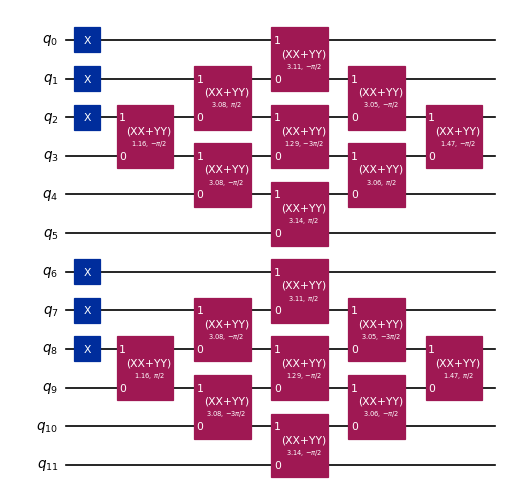

In [6]:
import ffsim
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit_ibm_runtime.fake_provider import FakeKyoto

backend = FakeKyoto()
qubits = QuantumRegister(mol.nao*2, name="q")
qc = QuantumCircuit(qubits)

qc.append(ffsim.qiskit.PrepareHartreeFockJW(mol.nao, mol.nelec), qubits)
qc.append(ffsim.qiskit.OrbitalRotationJW(mol.nao, (Ua.T, Ub.T)), qubits)

# Optimize the orbital rotation circuit for single Slater det
qc = ffsim.qiskit.PRE_INIT.run(qc)
qc_opt = transpile(qc, backend=backend, optimization_level=3)

# Decompose the orbital rotation into basic gates before drawing
decomposed = qc.decompose()
decomposed.draw("mpl", scale=0.6)

In [7]:
from qiskit_aer import Aer
from qiskit import transpile

# Transpile the circuit for the simulator
simulator = Aer.get_backend('statevector_simulator')
tqc = transpile(qc, simulator)

# Run and get results
job = simulator.run(tqc)
result = job.result()

# Extract the final statevector
statevector = result.get_statevector()

In [8]:
statevector.probabilities_dict()['111000111000']

0.002325733717139612

In [9]:
np.abs(statevector.data[int(0b111000111000)]) ** 2

0.002325733717139612

In [10]:
import pandas as pd

sv_abs = np.abs(statevector.data)
idx_sorted = np.argsort(sv_abs)[::-1]
sv_abs = sv_abs[idx_sorted]

bitstring_ints = np.arange(len(sv_abs))[idx_sorted]
bitstrings = [f"{x:012b}" for x in bitstring_ints]

df = pd.DataFrame({'Bitstring': bitstrings, 'Psi abs': sv_abs})
df = df.round(2)
print(df)

         Bitstring  Psi abs
0     000111000111     0.25
1     000111001011     0.22
2     001011000111     0.22
3     001011001011     0.20
4     010101000111     0.18
...            ...      ...
4091  100111110100     0.00
4092  100111110011     0.00
4093  100111110010     0.00
4094  100111110001     0.00
4095  100111111110     0.00

[4096 rows x 2 columns]


# Openfermion Hamiltonian

In [11]:
# from openfermion import get_fermion_operator, MolecularData, reorder
# from openfermion.linalg import get_sparse_operator
# from openfermion.utils import up_then_down
# from openfermionpyscf import run_pyscf
#
# # Take data from pyscf.Mole to build the equivalent openfermion object
# geometry = mol.atom
# basis = mol.basis
# multiplicity = mol.multiplicity
# charge = mol.charge
#
# # run_scf variable will cause the rhf orbital basis to be used for the hamiltonian
# md = MolecularData(geometry, basis, multiplicity, charge)
# md = run_pyscf(md, run_scf=1, run_ccsd=0, run_fci=0) # Don't do this!
# # Build Hamiltonian properly from fermion operators
#
# print(f"RHF energy from PySCF: {md.hf_energy:.6f} Ha")
#
# # Fermionic (second-quantized) Hamiltonian and sparse matrix on Fock space (2^n × 2^n)
# # fermion_ham is FermionOperator in interleaved spin ordering
# fermion_ham = get_fermion_operator(md.get_molecular_hamiltonian())
# # Reorder to seperated alpha then beta spin ordering
# fermion_ham = reorder(fermion_ham, up_then_down, num_modes=md.n_qubits)
#
# # Create sparse (ignore zero elements) Hamiltonian matrix
# H = get_sparse_operator(fermion_ham, n_qubits=md.n_qubits)

# My Hamiltonian

In [12]:
from hamiltonian.pyscf_glue import occ_hamiltonian_from_pyscf
H = occ_hamiltonian_from_pyscf(mol, rhf)

In [13]:
qsci_energy = (statevector.data.conj() @ (H @ statevector.data)).real
uhf_energy = uhf.e_tot
rhf_energy = rhf.e_tot
print(qsci_energy, uhf_energy, rhf_energy)

-2.819489899125406 -2.819489899125408 -2.3684212842825723


# FCI for comparison

In [14]:
from pyscf import fci

ci_solver = fci.FCI(rhf)
fci_energy, fci_vec = ci_solver.kernel()
fci_s2 ,mult = ci_solver.spin_square(fci_vec, mol.nao, mol.nelec)

# Calculate and compare energies

In [15]:
from scipy import linalg

idx = np.argwhere(np.abs(statevector.data) > 1e-12).ravel()
print("# of configs:", len(idx))
H_sub = H[idx, :][:, idx]
H_sub = H_sub.toarray()
evals, evecs = linalg.eigh(H_sub)

print("fci energy:", fci_energy)
print("rhf energy:", rhf.e_tot)
print("uhf energy:", uhf.e_tot)
print("qsci energy:", min(evals))

# of configs: 400
fci energy: -2.8471921339556028
rhf energy: -2.3684212842825723
uhf energy: -2.819489899125408
qsci energy: -2.8471921339556


In [16]:
(statevector.data.conj().T @ H @ statevector.data).real

-2.819489899125406

In [17]:
H_red = np.zeros(H.shape, dtype=complex)
H_red[np.ix_(idx, idx)] = H_sub
(statevector.data.conj().T @ H_red @ statevector.data).real

-2.8194898991254065

In [18]:
rhf_bitstring = 0b111000111000
rhf_idx = int(rhf_bitstring)
H[rhf_idx, rhf_idx].real # check indexing is correct

-1.5282443695282484

# Calculate and compare spin

In [19]:
from spin import total_spin_S2

S2_fermi = total_spin_S2(mol.nao)
rhf_s2 = S2_fermi[rhf_idx, rhf_idx].real # should be 0

# UHF total spin
uhf_s2, uhf_multiplicity = uhf.spin_square()

# QSCI subspace of S2 matrix
S2_fermi = S2_fermi[idx, :][:, idx]
grnd_idx = np.argmin(evals)
qsci_grnd = evecs[grnd_idx]

# Check it is the ground state
print(qsci_grnd.conj().T @ H_sub @ qsci_grnd.conj())


# psi is a normalized statevector (numpy complex array, dimension = 2**(2*norb))
qsci_s2 = (qsci_grnd.conj().T @ S2_fermi @ qsci_grnd).real

print("fci spin:", fci_s2)
print("rhf spin:", rhf_s2)
print("uhf spin:", uhf_s2)
print("qsci spin:", qsci_s2)

(-2.1191574026182614+0j)
fci spin: 2.6564890983317573e-27
rhf spin: 0.0
uhf spin: 2.7401010896064
qsci spin: 1.2186141422039958


# Check spin flipped states
See if for every sampled state the spin flipped state has also been sampled

In [20]:
n_bits = mol.nao * 2
sampled_configs = [f"{i:>0{n_bits}b}" for i in idx]
non_symm_configs = []
symm_configs = set()
for config in sampled_configs:
    half = len(config) // 2
    spin_swapped = config[half:] + config[:half]
    if spin_swapped not in sampled_configs:
        non_symm_configs.append(config)
    symm_configs.add(config)
    symm_configs.add(spin_swapped)

In [21]:
from scipy.sparse.linalg import eigsh

idx_symm = [int(x, 2) for x in symm_configs]
idx_symm = sorted(set(idx_symm))
print("# of configs:", len(idx_symm))
H_sub = H[np.ix_(idx_symm, idx_symm)]
# H_sub = H_sub.toarray()
# evals, evecs = linalg.eigh(H_sub)

E0, psi0 = eigsh(H_sub, k=1, which='SA')

print("fci energy:", fci_energy)
print("rhf energy:", rhf.e_tot)
print("uhf energy:", uhf.e_tot)
# print("qsci energy:", min(evals))
print("qsci energy:", E0)
print((psi0.conj().T @ H_sub @ psi0).real)

# of configs: 400
fci energy: -2.8471921339556028
rhf energy: -2.3684212842825723
uhf energy: -2.819489899125408
qsci energy: [-2.84719213]
[[-2.84719213]]


In [22]:
psi0_count = np.argwhere(psi0 > 1e-12)

In [23]:
S2_fermi = total_spin_S2(mol.nao)
rhf_s2 = S2_fermi[rhf_idx, rhf_idx].real # should be 0

# UHF total spin
uhf_s2, uhf_multiplicity = uhf.spin_square()

# QSCI subspace of S2 matrix
S2_fermi = S2_fermi[np.ix_(idx_symm, idx_symm)]
# psi is a normalized statevector (numpy complex array, dimension = 2**(2*norb))
qsci_s2 = (psi0.conj().T @ S2_fermi @ psi0).real

print("fci spin:", fci_s2)
print("rhf spin:", rhf_s2)
print("uhf spin:", uhf_s2)
print("qsci spin:", qsci_s2)

fci spin: 2.6564890983317573e-27
rhf spin: 0.0
uhf spin: 2.7401010896064
qsci spin: [[-5.80558437e-18]]


In [24]:
from scipy.sparse.linalg import eigsh
E0, psi0 = eigsh(H, k=1, which='SA')

In [25]:
fci_configs = set(np.argwhere(np.abs(psi0) > 1e-12)[:,0])

# Why are the fci and qsci configs not matching up!?

In [26]:
intersect = fci_configs.intersection(idx_symm)

In [27]:
idx = set(idx)

In [28]:
S2_fermi = total_spin_S2(mol.nao)
grnd_idx = np.argmin(evals)
qsci_grnd = evecs[grnd_idx]

psi0 = np.ravel(psi0)
fci_s2 = (psi0.conj().T @ S2_fermi @ psi0).real
print("fci spin:", fci_s2)

qsci_grnd_full = np.zeros(psi0.shape, dtype=complex)
qsci_grnd_full[np.ix_(idx_symm)] = qsci_grnd
qsci_s2 = (qsci_grnd_full.conj().T @ S2_fermi @ qsci_grnd_full).real
print("qsci spin:", qsci_s2)

S2_fermi = S2_fermi[np.ix_(idx_symm, idx_symm)]
qsci_s2 = (qsci_grnd.conj().T @ S2_fermi @ qsci_grnd).real
print("qsci spin:", qsci_s2)

fci spin: -1.5580451371329436e-18
qsci spin: 1.2186141422039953
qsci spin: 1.2186141422039958


In [29]:
qsci_nonzero = np.argwhere(np.abs(grnd) > 1e-12)

NameError: name 'grnd' is not defined

In [ ]:
fci_nonzero = np.argwhere(np.abs(psi0) > 1e-12)